<a href="https://colab.research.google.com/github/danish-khan962/Deep-Learning/blob/main/05_transfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tranfer learning with Tensorflow : Fine Tuning**

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning : **Fine Tuning**

## Creating Helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is a headache.


So it's a good idea to put functions we'll use again in a script that we can download and import in our notebooks.

Here are some helper functions we already created before : https://github.com/danish-khan962/Deep-Learning/blob/main/scripts/helper_functions.py

In [2]:
!wget https://raw.githubusercontent.com/danish-khan962/Deep-Learning/main/scripts/helper_functions.py

--2025-09-03 10:14:06--  https://raw.githubusercontent.com/danish-khan962/Deep-Learning/main/scripts/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-09-03 10:14:06 (19.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Getting data

This time we're going to see how we can use the pre-trained models within `tf.keras.applications` and apply them to our own problem.

In [4]:
# Get 10% of training data of 10 classes of Food 101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2025-09-03 10:21:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.207, 173.194.194.207, 173.194.195.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   155MB/s    in 1.0s    

2025-09-03 10:21:48 (155 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [6]:
# Creating training and test directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [7]:
import tensorflow as tf
print("Tensorflow version we're using: ", tf.__version__)

Tensorflow version we're using:  2.19.0


In [8]:
IMG_SIZE=(224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
# Class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[2.09132652e+01 1.10714283e+01 1.21989794e+01]
   [1.83112240e+01 1.41173477e+01 1.12806129e+01]
   [1.44795914e+01 1.66224499e+01 1.01275511e+01]
   ...
   [1.45051165e+01 1.45051165e+01 1.65051155e+01]
   [1.36428576e+01 1.36428576e+01 1.56428576e+01]
   [1.46428576e+01 1.46428576e+01 1.66428566e+01]]

  [[1.71683674e+01 1.30255098e+01 1.40051022e+01]
   [1.97857151e+01 1.57857151e+01 1.46530628e+01]
   [1.53979607e+01 1.21734695e+01 7.41326571e+00]
   ...
   [1.32703876e+01 1.32703876e+01 1.52703876e+01]
   [1.40714283e+01 1.40714283e+01 1.60714283e+01]
   [1.31428566e+01 1.31428566e+01 1.51428566e+01]]

  [[1.66632652e+01 1.60204086e+01 1.43061228e+01]
   [2.48826561e+01 1.65561237e+01 1.41836739e+01]
   [3.11683674e+01 1.35969391e+01 8.16836739e+00]
   ...
   [1.25714064e+01 1.25714064e+01 1.45714064e+01]
   [1.60867500e+01 1.60867500e+01 1.80867500e+01]
   [1.49948559e+01 1.49948559e+01 1.69948559e+01]]

  ...

  [[2.39744205e+01 2.39744205e+01 2.55458927e+01]
   [1

## Modelling experiments we're running

| Experiment | Data | Preprocessing | Model |
| -------- | --------| ---------| ---------|
| Model 0(baseline) | 10 classes of Food101 (**random 10%** training data only)| None | **Feature Extractor:** EfficientNetb0 (pre-trained on ImageNet, all layers frozen) with no top |
| Model 1 | 10 classes of Food101 (**random 1%** training data only) | Random Flip, rotation, zoom, height, width, data augmentation | Same as Model 0 |
| Model 2 | Same as Model 0 | Same as model 1 | Same as Model 0 |
| Model 3 | Same as Model 0 | Same as Model 1 | **Fine tuning** Model 2 (EfficientnetB0 pre-trained on ImageNet) **with top layers trained on custom data, top 10 layers unfrozen** |
| Model 4 | 10 classes of Food101 (**random 100%** training data) | Same as Model 1 | Same as Model 3 |

## **Model 0:** Creating Model with Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.

In [14]:
# 1. Creating baseline model with tf.keras.applications

base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't update during training)
base_model.trainable = False

# 3. Create inputs
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs
# (Don't have to normalize for EfficientNetB0)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs to base_model: {x.shape}")

# 6. Average pool the outputs (aggregate all most important information, reducing number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine inputs with outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

# 10. Fit the model
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch = len(train_data_10_percent),
                        validation_data = test_data,
                        validation_steps = int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="tranfer_learning",
                                                               experiment_name= "10_percent")])

Shape after passing inputs to base_model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: tranfer_learning/10_percent/20250903-111447
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 122s 5s/step - accuracy: 0.2456 - loss: 2.1791 - val_accuracy: 0.7039 - val_loss: 1.3722
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.7676 - loss: 1.2006 - val_accuracy: 0.8092 - val_loss: 0.9232
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 114s 5s/step - accuracy: 0.8129 - loss: 0.8571 - val_accuracy: 0.8289 - val_loss: 0.7511
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.8396 - loss: 0.7100 - val_accuracy: 0.8388 - val_loss: 0.6487
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 146s 5s/step - accuracy: 0.8645 - loss: 0.5887 - val_accuracy: 0.8388 - val_loss: 0.6113


In [15]:
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.8450 - loss: 0.5919


[0.5563188195228577, 0.8615999817848206]

In [16]:
# Let's check summary of base model
base_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, None,      │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, None,      │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, None,      │          0 │ normalization_2[… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, None,      │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ stem_conv_pad[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 32)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [17]:
# Checking layers of model_0
model_0.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,088,003 (15.59 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 25,622 (100.09 KB)

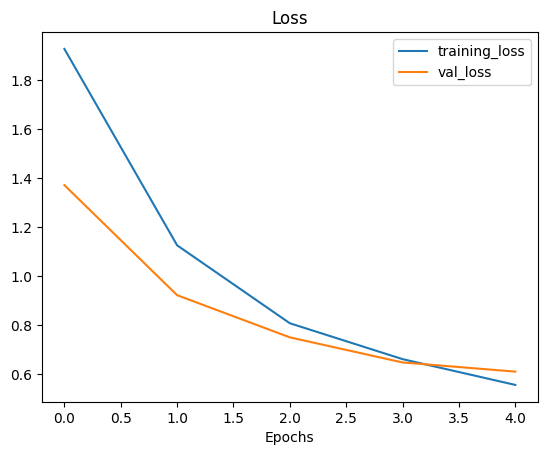

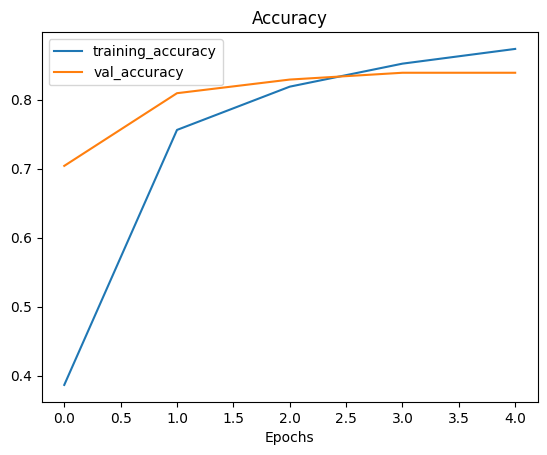

In [19]:
# Plotting loss curves
plot_loss_curves(history_0)